In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

project_path = "/content/drive/MyDrive/disease_prediction_gene_expression"
os.makedirs(project_path, exist_ok=True)

print(f"Project folder created at: {project_path}")


Project folder created at: /content/drive/MyDrive/disease_prediction_gene_expression


In [3]:
folders = ["notebooks", "data/raw", "data/processed", "models", "scripts", "app"]
for folder in folders:
    os.makedirs(os.path.join(project_path, folder), exist_ok=True)

In [4]:
import kagglehub

path = kagglehub.dataset_download('raghadalharbi/breast-cancer-gene-expression-profiles-metabric')
print("Dataset path:", path)


Dataset path: /kaggle/input/breast-cancer-gene-expression-profiles-metabric


In [5]:
import os

path = "/kaggle/input/breast-cancer-gene-expression-profiles-metabric"
for file in os.listdir(path):
    print(file)


METABRIC_RNA_Mutation.csv


In [6]:
import pandas as pd

data_path = "/kaggle/input/breast-cancer-gene-expression-profiles-metabric/METABRIC_RNA_Mutation.csv"

df = pd.read_csv(data_path)

df.head()


<ipython-input-6-41361e250ae3>:5: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.shape
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB


In [8]:
print(df.isnull().sum().sort_values(ascending=False).head(10))

tumor_stage                  501
3-gene_classifier_subtype    204
primary_tumor_laterality     106
neoplasm_histologic_grade     72
cellularity                   54
mutation_count                45
er_status_measured_by_ihc     30
type_of_breast_surgery        22
tumor_size                    20
cancer_type_detailed          15
dtype: int64


In [9]:
print(df.columns[df.columns.str.contains("os|death|survival", case=False)])

duration_col = "overall_survival_months"
event_col = "death_from_cancer"


Index(['age_at_diagnosis', 'lymph_nodes_examined_positive',
       'nottingham_prognostic_index', 'overall_survival_months',
       'overall_survival', 'death_from_cancer', 'ros1', 'ros1_mut'],
      dtype='object')


In [10]:
df[duration_col]

,overall_survival_months
0,140.500000
1,84.633333
2,163.700000
3,164.933333
4,41.366667
...,...
1899,196.866667
1900,44.733333
1901,175.966667
1902,86.233333


In [11]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=0f40ee741a42f574fdae7a829d8a52f870d80c9bd9588a57370c789ff807f206
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [11]:
df[event_col] = df[event_col].map({
    'Living': 0,
    'Died of Disease': 1,
    'Died of Other Causes': 1
})


In [12]:
df[duration_col] = pd.to_numeric(df[duration_col], errors='coerce')


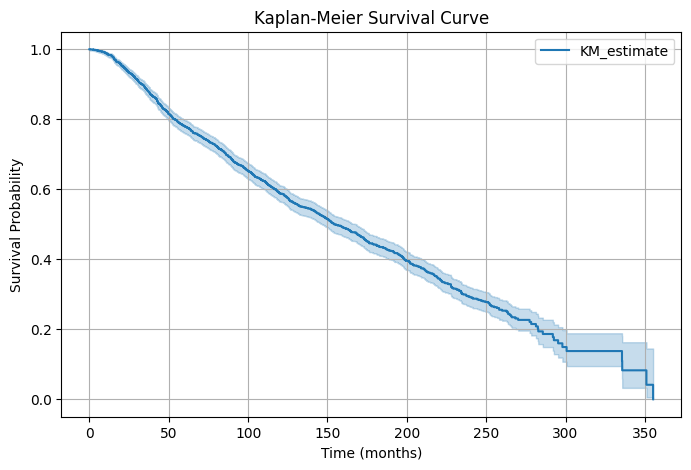

In [13]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

df_clean = df[[duration_col, event_col]].dropna()

kmf = KaplanMeierFitter()
kmf.fit(df_clean[duration_col], event_observed=df_clean[event_col])

plt.figure(figsize=(8, 5))
kmf.plot()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.grid()
plt.show()

In [14]:
categoricals = df.select_dtypes(include='object').columns
print(categoricals)


Index(['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed',
       'cellularity', 'pam50_+_claudin-low_subtype',
       'er_status_measured_by_ihc', 'er_status',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype',
       ...
       'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut',
       'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'],
      dtype='object', length=189)


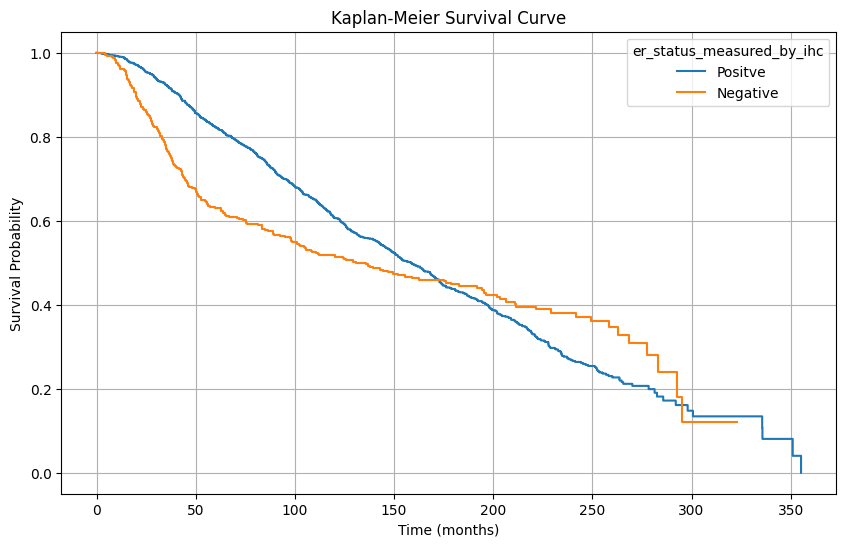

In [15]:
er_col = 'er_status_measured_by_ihc'

df_clean = df[[duration_col, event_col, er_col]].dropna()

plt.figure(figsize=(10, 6))

for er in df_clean[er_col].unique():
    ix = df_clean[er_col] == er

    kmf = KaplanMeierFitter(label=str(er))  # label metin olmalı
    kmf.fit(df_clean.loc[ix, duration_col], event_observed=df_clean.loc[ix, event_col])
    kmf.plot(ci_show=False)

plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend(title=er_col)
plt.grid()
plt.show()



In [16]:
from lifelines import CoxPHFitter

In [18]:
selected_cols = [
    duration_col,
    event_col,
    er_col,
    'pr_status',
    'her2_status'
]

In [19]:
df_cox = df[selected_cols].dropna().copy()

df_cox_encoded = pd.get_dummies(df_cox, drop_first=True)

cph = CoxPHFitter()
cph.fit(df_cox_encoded, duration_col=duration_col, event_col=event_col)

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1873 total observations, 785 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'death_from_cancer'
      baseline estimation = breslow
   number of observations = 1873
number of events observed = 1088
   partial log-likelihood = -7406.05
         time fit was run = 2025-05-26 14:29:33 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
er_status_measured_by_ihc_Positve  0.07      1.08      0.08           -0.09            0.24                0.91                1.27
pr_status_Positive                -0.21      0.81      0.07           -0.35           -0.08                0.71                0.93
her2_status_Positive               0.32      1.38      0.09            0.14            0.51                1.15                1.66

                                   cmp to     z      p  -log2(p)
covariate                                                       
er_status_measured_by_ihc_Positve    0.00  0.87   0.38      1.38
pr_status_Positive                   0.00 -3.07 <0.005      8.88
her2_status_Positive                 0.00  3.43 <0.005     10.68
---
Concordance = 0.56
Partial AIC = 14818.09
log-likelihood ratio test = 25.30 on 3 df
-log2(p) of ll-ratio test = 16.19

In [20]:
stat = df.iloc[:,32:].describe()
list_c = stat.columns
stat

,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,...,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03
mean,-4.201681e-07,3.676471e-07,-8.928571e-07,6.302521e-07,-2.100840e-07,0.000002,7.463684e-18,-3.676471e-07,-0.000001,-4.726891e-07,...,4.726891e-07,-3.676471e-07,-9.453782e-07,-1.050420e-07,-0.000002,3.676471e-07,4.726891e-07,7.878151e-07,0.000000,3.731842e-18
std,1.000262e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263,1.000262e+00,1.000263e+00,1.000262,1.000263e+00,...,1.000263e+00,1.000262e+00,1.000262e+00,1.000263e+00,1.000262,1.000264e+00,1.000262e+00,1.000263e+00,1.000262,1.000262e+00
min,-2.783500e+00,-4.384600e+00,-5.932800e+00,-2.481200e+00,-3.170500e+00,-3.323700,-2.688700e+00,-3.689800e+00,-2.968600,-3.060200e+00,...,-2.120800e+00,-3.364800e+00,-2.719400e+00,-4.982700e+00,-2.981700,-3.833300e+00,-3.609300e+00,-1.166900e+00,-2.112600,-1.051600e+00
25%,-6.994750e-01,-6.798250e-01,-5.586500e-01,-6.661500e-01,-6.602250e-01,-0.458600,-7.385500e-01,-6.667750e-01,-0.683925,-6.838250e-01,...,-6.188500e-01,-6.104750e-01,-6.741750e-01,-6.136750e-01,-0.632900,-6.664750e-01,-7.102000e-01,-5.058250e-01,-0.476200,-7.260000e-01
50%,-5.820000e-02,-2.210000e-02,1.098500e-01,-3.010000e-02,-4.200000e-03,0.115550,-1.311000e-01,-1.445000e-02,-0.054800,-5.785000e-02,...,-2.456500e-01,-4.690000e-02,-1.422500e-01,-5.175000e-02,-0.026650,7.000000e-04,-2.980000e-02,-2.885500e-01,-0.133400,-4.248000e-01
75%,6.290000e-01,6.400000e-01,6.426250e-01,6.447500e-01,6.901500e-01,0.649800,5.431250e-01,6.387250e-01,0.668925,5.362750e-01,...,3.306000e-01,5.144500e-01,5.146000e-01,5.787750e-01,0.590350,6.429000e-01,5.957250e-01,6.022500e-02,0.270375,4.284000e-01
max,3.737900e+00,4.615000e+00,3.254100e+00,4.289800e+00,3.824200e+00,2.820900,4.538200e+00,5.371300e+00,6.178600,4.850100e+00,...,6.534900e+00,1.027030e+01,6.329000e+00,4.571300e+00,12.742300,3.938800e+00,3.833400e+00,1.088490e+01,12.643900,3.284400e+00


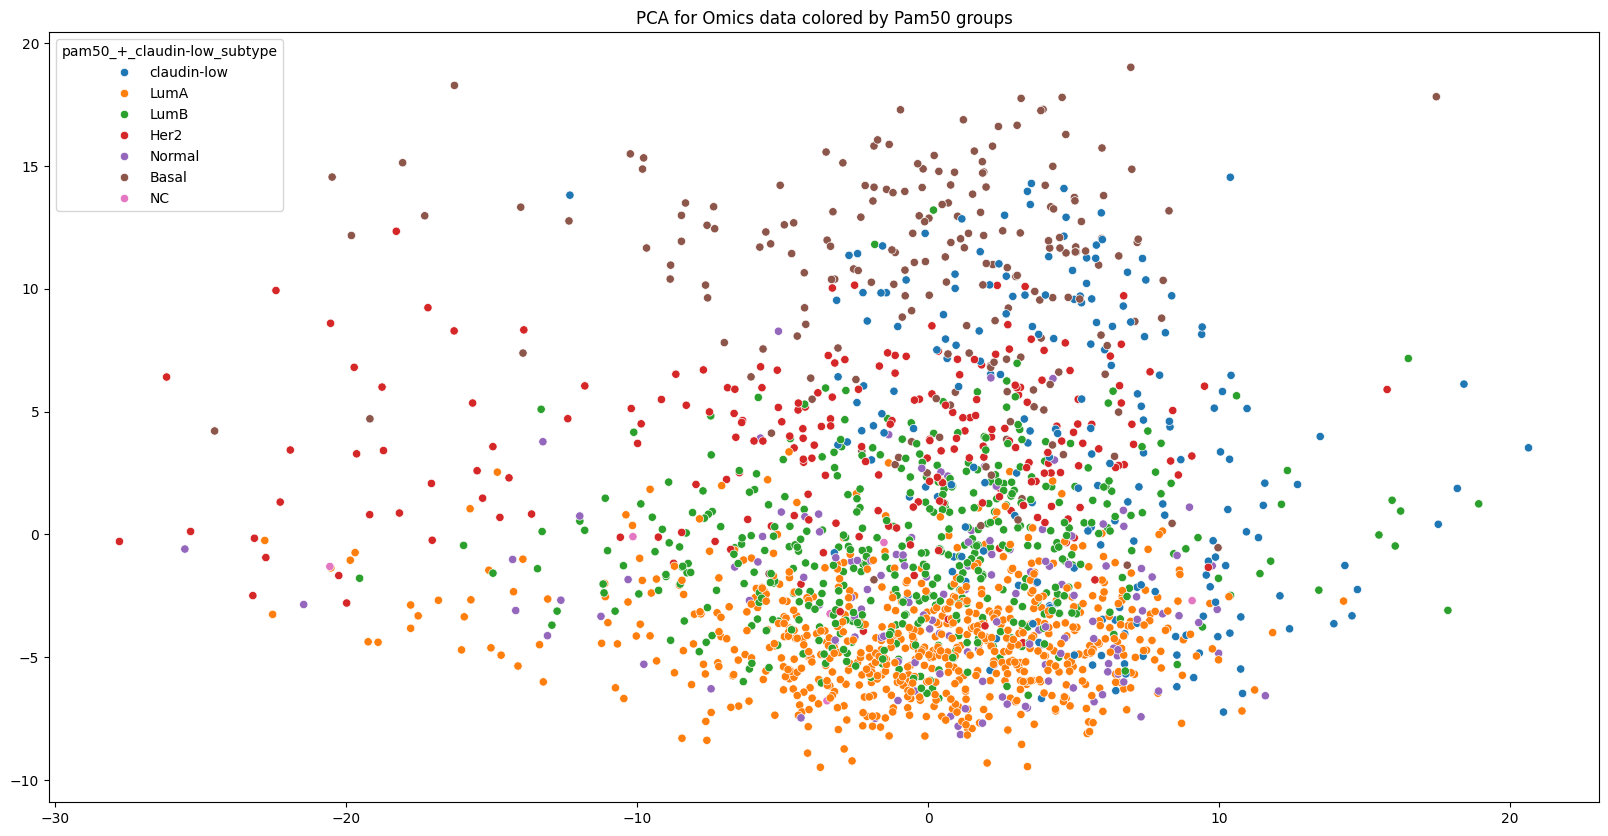

In [21]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca = PCA
r = pca().fit_transform(X = df[list_c].values)
f = 'pam50_+_claudin-low_subtype' # 'Pam50 + Claudin-low subtype'
plt.figure(figsize = (20,10))
sns.scatterplot( x=r[:,0], y=r[:,1], hue = df[f] )
plt.title('PCA for Omics data colored by Pam50 groups')
plt.show()

In [22]:
for f in df.columns[:32]:
    plt.figure(figsize = (20,5))
    sns.scatterplot( x=r[:,0], y=r[:,1], hue = df[f] )
    plt.title('PCA for Omics data colored by' + f)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [23]:
cat_clinical_columns = ['chemotherapy', 'cohort', 'neoplasm_histologic_grade','hormone_therapy', 'radio_therapy', 'tumor_stage' ]

df[cat_clinical_columns].astype('category').describe().T

,count,unique,top,freq
chemotherapy,1904.0,2.0,0.0,1508.0
cohort,1904.0,5.0,3.0,734.0
neoplasm_histologic_grade,1832.0,3.0,3.0,927.0
hormone_therapy,1904.0,2.0,1.0,1174.0
radio_therapy,1904.0,2.0,1.0,1137.0
tumor_stage,1403.0,5.0,2.0,800.0


In [24]:
df.select_dtypes(include=['object']).astype('category').describe().T

,count,unique,top,freq
type_of_breast_surgery,1882,2,MASTECTOMY,1127
cancer_type,1904,2,Breast Cancer,1903
cancer_type_detailed,1889,6,Breast Invasive Ductal Carcinoma,1500
cellularity,1850,3,High,939
pam50_+_claudin-low_subtype,1904,7,LumA,679
...,...,...,...,...
hras_mut,1904,4,0,1024
prps2_mut,1904,3,0,1902
smarcb1_mut,1904,4,0,1024
stmn2_mut,1904,3,0,1902


In [25]:
# Find all categorical (object type) columns
cat_cols = df.select_dtypes(include='object').columns
print("🔎 Categorical columns:")
print(cat_cols.tolist())


🔎 Categorical columns:
['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'oncotree_code', 'pr_status', '3-gene_classifier_subtype', 'pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut', 'syne1_mut', 'gata3_mut', 'map3k1_mut', 'ahnak_mut', 'dnah11_mut', 'cdh1_mut', 'dnah2_mut', 'kmt2d_mut', 'ush2a_mut', 'ryr2_mut', 'dnah5_mut', 'herc2_mut', 'pde4dip_mut', 'akap9_mut', 'tg_mut', 'birc6_mut', 'utrn_mut', 'tbx3_mut', 'col6a3_mut', 'arid1a_mut', 'lama2_mut', 'notch1_mut', 'cbfb_mut', 'ncor2_mut', 'col12a1_mut', 'col22a1_mut', 'pten_mut', 'akt1_mut', 'atr_mut', 'thada_mut', 'ncor1_mut', 'stab2_mut', 'myh9_mut', 'runx1_mut', 'nf1_mut', 'map2k4_mut', 'ros1_mut', 'lamb3_mut', 'arid1b_mut', 'erbb2_mut', 'sf3b1_mut', 'shank2

In [26]:
# Check for potential target columns
for col in df.columns:
    if "death" in col.lower():
        print("🧪 Suitable target column found:", col)


🧪 Suitable target column found: death_from_cancer


In [27]:
target_col = "death_from_cancer"

for col in cat_cols:
    if col != target_col:
        cross_tab = pd.crosstab(df[col], df[target_col])
        cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)

        cross_tab_norm.plot(kind='bar', stacked=True, figsize=(8,4), colormap="Set2")
        plt.title(f"📊 {col} vs {target_col}")
        plt.ylabel("Rate")
        plt.xticks(rotation=45)
        plt.grid(axis="y")
        plt.legend(title=target_col)
        plt.tight_layout()
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [28]:
y = df[event_col]
clinic_cols = df[cat_clinical_columns]
gene_cols = df.columns[32:]

In [29]:
X_clinic = clinic_cols.copy()

# If these columns are numeric but actually categorical, convert them to category type:
X_clinic['tumor_stage'] = X_clinic['tumor_stage'].astype('category')
X_clinic['cohort'] = X_clinic['cohort'].astype('category')

# Apply one-hot encoding only to these two categorical columns:
X_clinic = pd.get_dummies(X_clinic, columns=['tumor_stage', 'cohort'], drop_first=True)


In [30]:
from sklearn.preprocessing import StandardScaler

# Gene columns were selected earlier (from column index 32 onward, as an example)
gene_cols = df.iloc[:, 32:].select_dtypes(include='number').columns

# Fill missing values with column means
X_gene = df[gene_cols].fillna(df[gene_cols].mean())

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_gene_scaled = pd.DataFrame(scaler.fit_transform(X_gene), columns=gene_cols)


In [31]:
import pandas as pd

# Reset and merge indexes
X_final = pd.concat([X_clinic.reset_index(drop=True), X_gene_scaled.reset_index(drop=True)], axis=1)


In [32]:
y

,death_from_cancer
0,0.0
1,0.0
2,1.0
3,0.0
4,1.0
...,...
1899,0.0
1900,1.0
1901,1.0
1902,1.0


In [33]:
X_final = X_final[y.notnull()]
y_final = y[y.notnull()]


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[ 62  83]
 [ 62 174]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.43      0.46       145
         1.0       0.68      0.74      0.71       236

    accuracy                           0.62       381
   macro avg       0.59      0.58      0.58       381
weighted avg       0.61      0.62      0.61       381

Accuracy: 0.6194225721784777


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


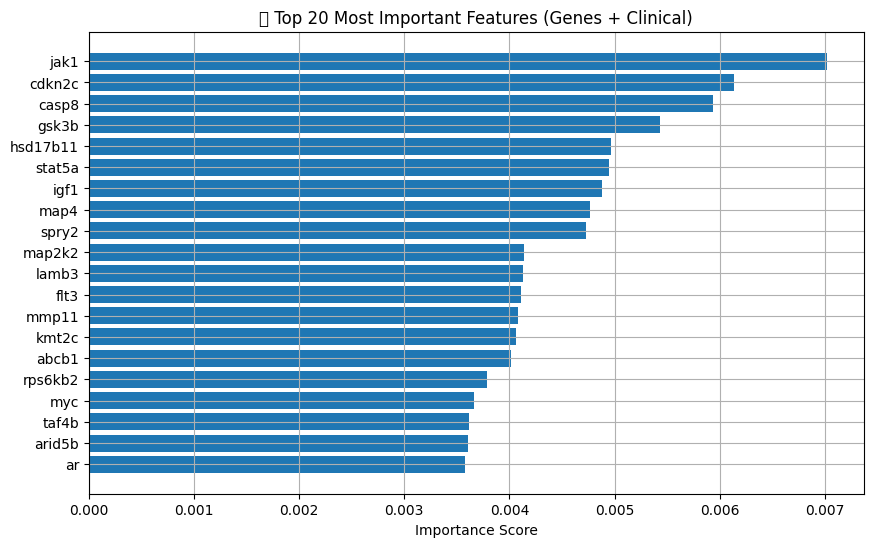

In [36]:
import numpy as np

# Get feature importances from the trained model
importances = model.feature_importances_
indices = np.argsort(importances)[-20:]  # show the top 20 most important features

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), X_final.columns[indices])
plt.xlabel("Importance Score")
plt.title("🔍 Top 20 Most Important Features (Genes + Clinical)")
plt.grid()
plt.show()


In [37]:
!pip install xgboost --quiet


In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)


In [40]:
model2 = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model2.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [41]:
y_pred = model2.predict(X_test)
y_proba = model2.predict_proba(X_test)[:, 1]  # for ROC-AUC

print("🎯 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("🔥 ROC-AUC Score:", roc_auc_score(y_test, y_proba))


🎯 Confusion Matrix:
 [[ 78  82]
 [ 63 158]]

📄 Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.49      0.52       160
         1.0       0.66      0.71      0.69       221

    accuracy                           0.62       381
   macro avg       0.61      0.60      0.60       381
weighted avg       0.61      0.62      0.62       381

✅ Accuracy: 0.6194225721784777
🔥 ROC-AUC Score: 0.6369626696832579


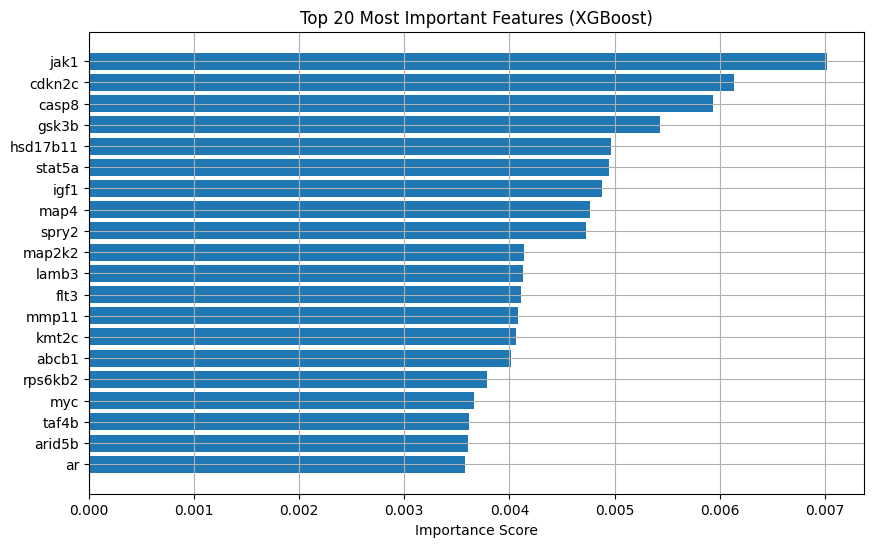

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the model
importances = model.feature_importances_
indices = np.argsort(importances)[-20:]  # indices of the top 20 features

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), X_final.columns[indices])
plt.xlabel("Importance Score")
plt.title("Top 20 Most Important Features (XGBoost)")
plt.grid()
plt.show()


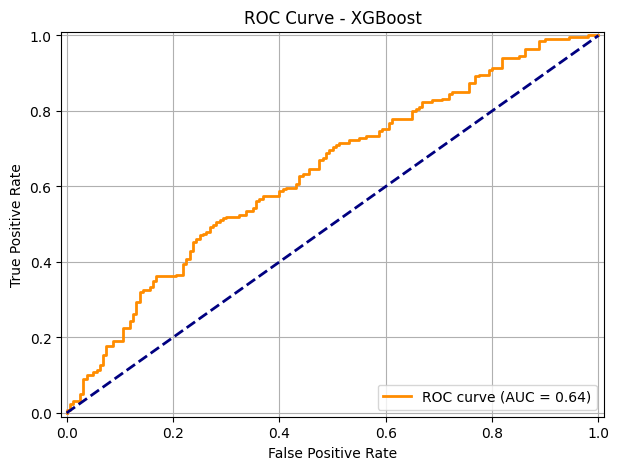

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = model2.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid()
plt.show()
